# **1. Introduction**

Customer churn occurs when a customer stops using a business's products or services. Customer retention is critical to the business as it is often more costly to acquire new customers compared to retaining existing ones. As such, predicting customer churn will help in early detection of customers who are at risks of leaving a service/product, allowing the business to take proactive measures in prioritising retention efforts with these customers. 

In [1]:
# !pip install pydotplus
# !pip install six

In [2]:
#import libs
import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix ,classification_report,precision_score, recall_score ,f1_score, accuracy_score 

#decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

In [3]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# **2. Data Processing**
The overall data quality is quite good. There are no duplicates and outliers. There is only a handful of missing values for TotalCharges which was replaced with 0.

### 2A. Check data type, missing values and duplicates
As TotalCharges is a float and SeniorCitizen is a dummy variable, I have corrected the data type.

In [4]:
#check data type
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
#convert data type
df['TotalCharges'] = df['TotalCharges'].str.replace(" ", "0", regex=False) #regex=False means input string is not a regex pattern
df['TotalCharges'] = df['TotalCharges'].astype('float64')
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

In [6]:
#check for duplicate values - no duplicates
df['customerID'].duplicated().sum()

0

In [7]:
#drop irrelevant columns - customerID
df.index = df['customerID']
df = df.drop(columns='customerID')

In [8]:
#check for missing values
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 2B. Check for outliers
As seen from the summary stats table and boxplot below:
- tenure is positively skewed as mean is greater than median monthly charges
- MonthlyCharges is negatively skewed as mean is lower than median monthly charges
- TotalCharges is positively skewed as mean is greater than median total charges
- Based on the IQR formula, there are no outliers

In [9]:
#check outliers using mean and median
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


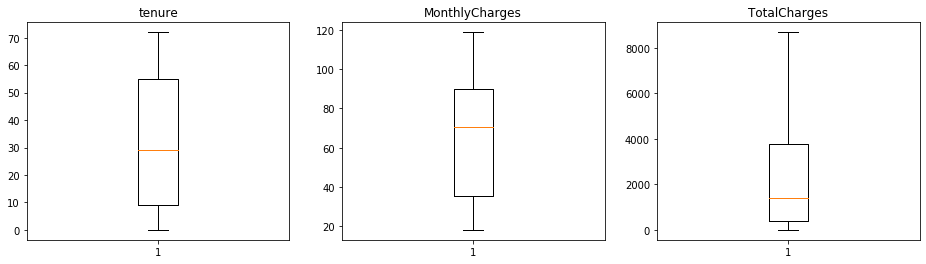

In [10]:
#check outliers using boxplot
numeric_col = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, ax = plt.subplots(1,3, figsize=(16, 4)) 

#enumerate adds a counter to iterable
for n, each_col in enumerate(numeric_col):
    ax[n].boxplot(df[each_col]) 
    ax[n].set_title(each_col)

# 3. Exploratory Data Analysis

In [11]:
numerical_col = []
cat_col = []
for each_feature in df.columns:
    if df[each_feature].dtypes == 'int64' or df[each_feature].dtypes == 'float64':
        numerical_col.append(each_feature)
    else:
        cat_col.append(each_feature)
        
print(numerical_col)
print(cat_col)

['tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


### 3A. Understand data distribution for each categorical variable
- In terms of demographic, this dataset is mainly made up customers who are young and has no dependents. 
- As for the firm's core services, 90% of the customers are subscribed to the firm's phone service. Out of these customers, majority of them own multiple lines. 77% of customers have subscribed to the firm's Internet service and out of these customers, 44% of customers are Fibre Optic users and 34% are DSL users.
- On average, across all the add-on service , 78% of customers do not subscribe or do not need add-on services such as Online Security, Online Backup, Device Protection, Tech Support, StreamingTV and StreamingMovies 
- Month-to-month contracts are more popular than 1-year and 2-year contracts
- This dataset has an unequal class distribution. 73% of the data represents existing customers while only 27% of the data represents churned customer. This could create an imbalanced classification issue where it will be more challeneging for the model to learn the characterisitics of the minority class (churned customers).

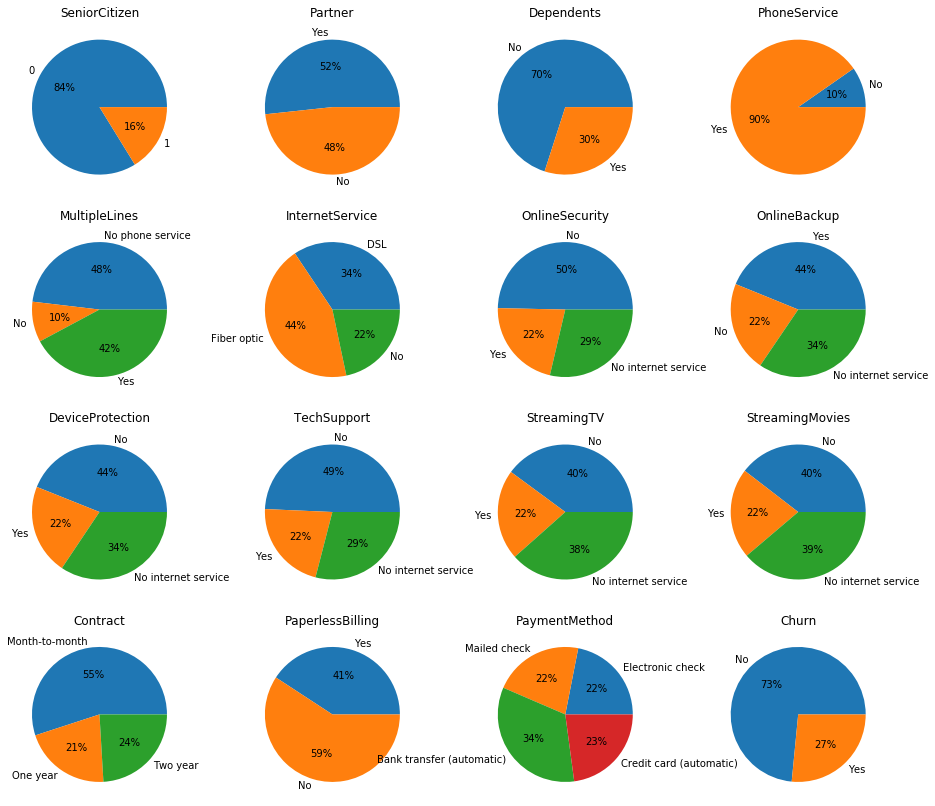

In [12]:
fig = plt.figure (figsize=(16, 18))
for y, each_feature in enumerate(cat_col[1:], start=1): #counter starts at 1, required by add_subplot
    x = fig.add_subplot(5,4,y) #5by4 plot, ax1 is subplot at position y
    x.pie(df.groupby(each_feature).size(), labels=df[each_feature].unique(), autopct=lambda p: '{:.0f}%'.format(p)) #autopct is the label for piechart, requires function
    x.set_title(each_feature) #set title for each subplot


### 3B. Understand relationship between numerical independent variable with dependent variable
- Churn customers have a shorter median tenure of 10 months, compared to non-churn customers who have a longer median tenure of 38 months
- Churn customers have a higher median monthly charge bill of \\$79.6 compared to non-churn customers who have a lower median monthly bill of \\$64.4.
- Yet, churn customers have a lower median total charge bill of \\$703.6 compared to non-churn customers who have a higher median total bill of \\$1079.5. This seems to contradict the findings from the monthly charge bill. A possible reason could be that churn customers have shorter tenure where they churn prematurely before the end of the fiscal period, resulting in lower total charges.

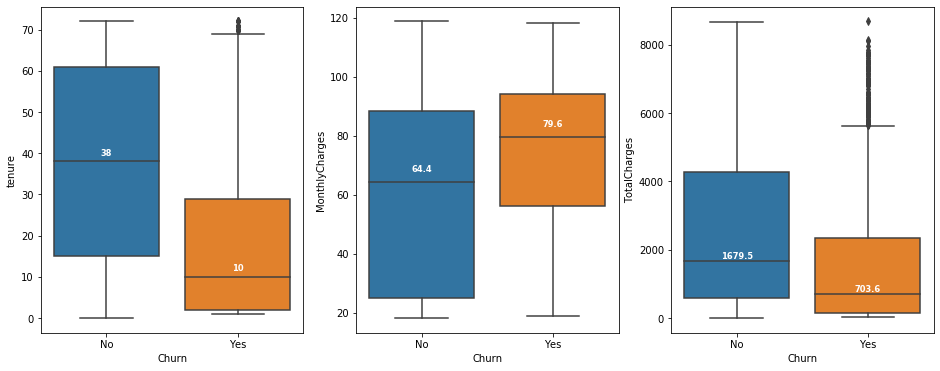

In [13]:
#numerical variables
fig, ax = plt.subplots(1,3, figsize=(16, 6)) 
for n, each_feature in enumerate(numeric_col):
    box_plot = sns.boxplot(ax=ax[n], y=each_feature, x = 'Churn', data=df)
    
    medians = round(df.groupby(df['Churn'])[each_feature].median(),1)
    vertical_offset = df[each_feature].median() * 0.05 # offset from median for display

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')

# 4. Classification Models

### 4A. Prepare data for analysis

In [14]:
#perform encoding for analysis
for each in cat_col:
    df[each] = df[each].astype('category')
    df[each] = df[each].cat.codes
    
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
5575-GNVDE,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
3668-QPYBK,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
7795-CFOCW,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
9237-HQITU,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [15]:
#split data into test and train
x = df.iloc[:,0:-1]
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

### 4B. Correcting imbalanced class distribution
Since it was detected that the dataset has unequal class distribution, I have performed oversampling to duplicate samples from the minority class to create equally distributed classes in the training dataset. 

In [16]:
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=[0,16], random_state = 2)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

# what we had before
print("what we had before")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# what we have now - an increase in training data, does not affect the test data
print("\nwhat we have now after oversampling")
print(x_train_sm.shape, y_train_sm.shape, x_test.shape, y_test.shape)

#class distribution
print("\nnew class distribution")
y_train_sm.value_counts()

what we had before
(4930, 19) (4930,) (2113, 19) (2113,)

what we have now after oversampling
(7222, 19) (7222,) (2113, 19) (2113,)

new class distribution


1    3611
0    3611
Name: Churn, dtype: int64

### 4C. Model #1 - Logistic Regression
Logistic regression is a classification algorithm that predicts a binary outcome (churn vs non-churn). The dependent variable is categorical while the independent variables can be continuous or categorical. 

**Verifying Assumption #1: The independent variables are linearly related to the log odds**

Logistic Regression assumes that the continuous dependent variables are linearly related to the log odds of the dependent variable. To verify this assumption, I have plot the continuous dependent predictor - monthly charges and total charges to the log odds of the dependent variable. We would expect a flat top and bottom with a increasing/decreasing middle. Indeed, we have validated the assumption that the 2 continuous predictor variables are linearly related to the log odds of the dependent variable.

Text(0.5, 1.0, 'Monthly Charges Log Odds Linear Plot')

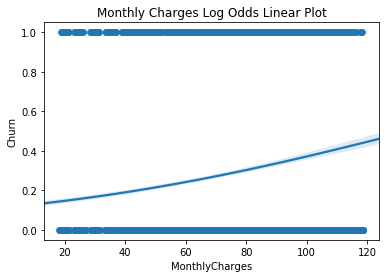

In [17]:
sns.regplot(x= 'MonthlyCharges', y= 'Churn', data= df, logistic= True).set_title("Monthly Charges Log Odds Linear Plot")

Text(0.5, 1.0, 'Total Charges Log Odds Linear Plot')

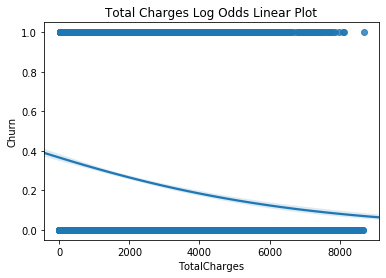

In [18]:
sns.regplot(x= 'TotalCharges', y= 'Churn', data= df, logistic= True).set_title("Total Charges Log Odds Linear Plot")

**Verifying Assumption #2: There is little to no multicollinearity between the independent variables**

Logistic Regression also assumes little to no multicollinearity. I have tested this by looking at the correlation between independent variables with Spearman and computed the variance inflation factor (VIF) score. In general, correlation > 0.7 and  VIF>10 indicates presence of multi-collinearity. As seen below, TotalCharges, Tenure, Phone Service and MonthlyCharges are at high risk of multi-collinearity and are removed from the dataset [1, 2, 6]. 

In [19]:
sm_df = x.corr(method='spearman')
sm_df.style.applymap(lambda x: "background-color: red" if x>0.7 else "background-color: white")

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
gender,1,-0.00187371,-0.00180808,0.0105166,0.00348627,-0.00648767,-0.00662578,-0.00151733,-0.0143189,-0.0118085,0.00076849,-0.00626276,-0.00638724,-0.00872566,0.00109389,-0.0117537,0.0171192,-0.0137365,-0.00139398
SeniorCitizen,-0.00187371,1,0.0164787,-0.211185,0.0185556,0.0085764,0.145968,-0.0169635,-0.141363,-0.0201572,-0.0280399,-0.163717,0.0297518,0.0467394,-0.14385,0.15653,-0.0437032,0.221067,0.108171
Partner,-0.00180808,0.0164787,1,0.452676,0.384931,0.0177057,0.142041,0.000899695,0.148804,0.152746,0.165893,0.125159,0.137336,0.129573,0.295925,-0.0148766,-0.155247,0.108463,0.340298
Dependents,0.0105166,-0.211185,0.452676,1,0.164175,-0.00176168,-0.0249486,0.0343728,0.161477,0.0957933,0.0854416,0.14282,0.0476642,0.0217232,0.24412,-0.111377,-0.0375898,-0.107011,0.0784087
tenure,0.00348627,0.0185556,0.384931,0.164175,1,0.00848314,0.348444,-0.0285748,0.318672,0.367451,0.370751,0.31746,0.29365,0.301412,0.667623,0.0076952,-0.379356,0.276417,0.889696
PhoneService,-0.00648767,0.0085764,0.0177057,-0.00176168,0.00848314,1,-0.037431,0.400349,-0.000943101,0.0302239,0.0100321,-0.0053548,0.0563133,0.0443647,0.00184151,0.0165048,-0.00380799,0.239701,0.0853706
MultipleLines,-0.00662578,0.145968,0.142041,-0.0249486,0.348444,-0.037431,1,-0.097689,-0.0151986,0.106652,0.111745,-0.0100749,0.172484,0.17933,0.107037,0.164786,-0.182721,0.46421,0.460102
InternetService,-0.00151733,-0.0169635,0.000899695,0.0343728,-0.0285748,0.400349,-0.097689,1,0.0200742,0.0609248,0.0708485,0.0208153,0.119093,0.107663,0.079586,-0.117944,0.0846861,-0.206889,-0.188862
OnlineSecurity,-0.0143189,-0.141363,0.148804,0.161477,0.318672,-0.000943101,-0.0151986,0.0200742,1,0.194121,0.185368,0.303877,0.0459262,0.0561474,0.392417,-0.181656,-0.080632,-0.108483,0.20813
OnlineBackup,-0.0118085,-0.0201572,0.152746,0.0957933,0.367451,0.0302239,0.106652,0.0609248,0.194121,1,0.192148,0.204336,0.147611,0.136782,0.293445,-0.0248606,-0.119225,0.111845,0.332762


In [20]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

             feature        VIF
0             gender   1.954601
1      SeniorCitizen   1.369688
2            Partner   2.821597
3         Dependents   1.964252
4             tenure  14.909449
5       PhoneService  15.138336
6      MultipleLines   2.752986
7    InternetService   4.352778
8     OnlineSecurity   2.249502
9       OnlineBackup   2.456172
10  DeviceProtection   2.632377
11       TechSupport   2.383056
12       StreamingTV   3.240299
13   StreamingMovies   3.262482
14          Contract   4.164086
15  PaperlessBilling   2.872170
16     PaymentMethod   3.097858
17    MonthlyCharges  20.455626
18      TotalCharges  13.822567


In [21]:
#drop columns with high multicollinearity
to_remove =['MonthlyCharges','TotalCharges', 'PhoneService', 'tenure']
logr_col = list(x.columns)
for each in to_remove:
    logr_col.remove(each)

In [22]:
#full formula 
output = x.columns[0]
for each in df.columns[1:-1]:
    output +=  " + " + each 
full_formula = 'Churn~ ' + output
full_formula

'Churn~ gender + SeniorCitizen + Partner + Dependents + tenure + PhoneService + MultipleLines + InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Contract + PaperlessBilling + PaymentMethod + MonthlyCharges + TotalCharges'

In [23]:
#removed columns with high multicollinearity
output = x.columns[0]
for each in logr_col:
    output +=  " + " + each 
r_formula = 'Churn~ ' + output
r_formula

'Churn~ gender + gender + SeniorCitizen + Partner + Dependents + MultipleLines + InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + Contract + PaperlessBilling + PaymentMethod'

**Model 1A - Logisitic Regression Model trained on original dataset**

In [24]:
#ref: https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/

#full dateset
model= smf.logit(formula=full_formula, data= x_train.join(y_train)).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.407437
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4910
Method:                           MLE   Df Model:                           19
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                  0.2985
Time:                        18:08:37   Log-Likelihood:                -2008.7
converged:                       True   LL-Null:                       -2863.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4945      0.229     -2.163      0.031      -0.943      -0.046
gender              -0.0060      0.078     -0.076      0.939      -0.159       0.147
SeniorCitizen        0.1976      0.102      1.944      0.052      -0.002       0.397
Partner              0.0158      0.094      0.169      0.866      -0.168       0.199
Dependents          -0.1415      0.109     -1.302      0.193      -0.354       0.071
tenure              -0.0680      0.008     -8.630      0.000      -0.083      -0.053
PhoneService        -0.9119      0.179     -5.097      0.000      -1.263      -0.561
MultipleLines        0.0644      0.049      1.308      0.191      -0.032       0.161
InternetService      0.2394      0.078      3.051      0.002       0.086       0.393
OnlineSecurity      -0.3212      0.051     -6.356      0.000      -0.420      -0.222
OnlineBackup        -0.1790      0.046     -3.910      0.000      -0.269      -0.089
DeviceProtection    -0.1259      0.047     -2.668      0.008      -0.218      -0.033
TechSupport         -0.2769      0.050     -5.534      0.000      -0.375      -0.179
StreamingTV          0.0007      0.050      0.014      0.988      -0.097       0.098
StreamingMovies      0.0283      0.050      0.573      0.567      -0.069       0.125
Contract            -0.6877      0.093     -7.372      0.000      -0.870      -0.505
PaperlessBilling     0.4160      0.090      4.629      0.000       0.240       0.592
PaymentMethod        0.0216      0.043      0.503      0.615      -0.062       0.106
MonthlyCharges       0.0228      0.003      8.492      0.000       0.018       0.028
TotalCharges         0.0004   8.83e-05      4.465      0.000       0.000       0.001
====================================================================================
"""

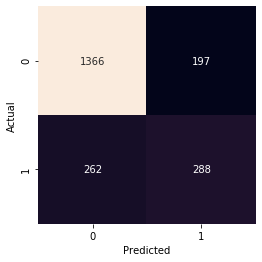

Test accuracy =  0.7827733080927591


In [25]:
ypred = model.predict(x_test)
ypred
prediction = list(map(round, ypred))

# confusion matrix
cm = confusion_matrix(y_test, prediction)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

In [26]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, prediction),'\n')
print(' recall score: ',recall_score(y_test, prediction),'\n')
print(classification_report(y_test, prediction))

 precision score:  0.5938144329896907 

 recall score:  0.5236363636363637 

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1563
           1       0.59      0.52      0.56       550

    accuracy                           0.78      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.78      0.78      0.78      2113



**Model 1B - Logistic Regression Model trained on dataset without the multi-collinear features**

In [28]:
model= smf.logit(formula=r_formula, data= x_train.join(y_train)).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.439116
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4914
Method:                           MLE   Df Model:                           15
Date:                Sat, 06 Nov 2021   Pseudo R-squ.:                  0.2440
Time:                        18:13:22   Log-Likelihood:                -2164.8
converged:                       True   LL-Null:                       -2863.4
Covariance Type:            nonrobust   LLR p-value:                7.204e-289
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5213      0.137     -3.819      0.000      -0.789      -0.254
gender              -0.0395      0.075     -0.528      0.597      -0.186       0.107
SeniorCitizen        0.2637      0.097      2.718      0.007       0.074       0.454
Partner             -0.1515      0.088     -1.724      0.085      -0.324       0.021
Dependents          -0.2172      0.104     -2.091      0.037      -0.421      -0.014
MultipleLines        0.1258      0.042      2.977      0.003       0.043       0.209
InternetService      0.0614      0.060      1.021      0.307      -0.057       0.179
OnlineSecurity      -0.4354      0.050     -8.633      0.000      -0.534      -0.337
OnlineBackup        -0.2588      0.044     -5.905      0.000      -0.345      -0.173
DeviceProtection    -0.1333      0.046     -2.912      0.004      -0.223      -0.044
TechSupport         -0.3211      0.050     -6.438      0.000      -0.419      -0.223
StreamingTV          0.1412      0.046      3.058      0.002       0.051       0.232
StreamingMovies      0.1593      0.046      3.466      0.001       0.069       0.249
Contract            -1.2910      0.081    -15.883      0.000      -1.450      -1.132
PaperlessBilling     0.5811      0.084      6.924      0.000       0.417       0.746
PaymentMethod        0.0629      0.039      1.594      0.111      -0.014       0.140
====================================================================================
"""

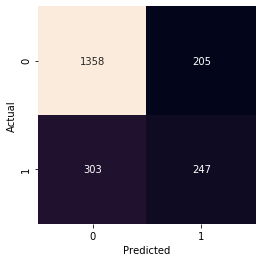

Test accuracy =  0.7595835305253195


In [29]:
ypred = model.predict(x_test)
ypred
prediction = list(map(round, ypred))

# confusion matrix
cm = confusion_matrix(y_test, prediction)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

In [30]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, prediction),'\n')
print(' recall score: ',recall_score(y_test, prediction),'\n')
print(classification_report(y_test, prediction))

 precision score:  0.5464601769911505 

 recall score:  0.4490909090909091 

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1563
           1       0.55      0.45      0.49       550

    accuracy                           0.76      2113
   macro avg       0.68      0.66      0.67      2113
weighted avg       0.75      0.76      0.75      2113



**Model 1C - Logisitic Regression Model trained on dataset corrected for imbalanced class**

In [31]:
#im dateset
model= smf.logit(formula=formula, data= x_train_sm.join(y_train_sm)).fit()
model.summary()

NameError: name 'formula' is not defined

In [ ]:
ypred = model.predict(x_test)
ypred
prediction = list(map(round, ypred))

# confusion matrix
cm = confusion_matrix(y_test, prediction)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, prediction))

In [ ]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, prediction),'\n')
print(' recall score: ',recall_score(y_test, prediction),'\n')
print(classification_report(y_test, prediction))

**Model Discussion**

- Although the first model (1A) produced a high accuracy score of 0.783, it has a low precision and recall scores at 0.594 and 0.524 respectively. The model performed well in terms of accuracy due to the accracy paradox - given that majority of the test data are of the majority class, a model that predicts the majority class for all the test data will have a high number of correct predictions. This results in a misleading accuracy score. 
- As such, I trained a second model (1B) with a balanced data set to evaluate if this would improve the recall and precision. Although the accuracy score decreased slightly to 0.746, the recall score has improved to 0.715. However, the precision score decreased to 0.508. This is the trade-off for correcting the dataset. As the model is now exposed to more data from the minority class (churn), more of its prediction now leans towards the minority class, resulting in higher false positives and thus, a lower precision. 
- Given both models, I would pick the second model (1B) as it has a higher recall. In this customer churn prediction case, false positives are less costly compared to false negatives. In a false positive case, the firm would proactively engage a non-churn customer as the model has wrongly predicted that the customer would churn. In a false negative case, the firm would neglect a churning customer as the model has wrongly predicted that the customer would not churn. The latter would cause greater financial loss to the firm as it is more expensive to acquire a new customer than to retain one. 

**Intepreting model output  [4]**
- StreamingMovies, PaperlessBilling and gender have no significant effect on the log odds of customers churning. (p-value>0.05)
- The remaining independent variables have a significant effect on the log odds of customer churning (p-value<0.05)
- Customers subscribed to phone service has a -1.43 decrease in log odds of churning compared to customers who are not subscribed to phone service
- Customers who have dependents has a -0.67 decrease in log odds of churning compared to customers who do not have dependents
- Senior citizen customers have a -0.61 decrease in log odds of churning compared to customers who are younger.


### 4D. Model #2 - Decision Tree
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(x_train_sm,y_train_sm)
y_pred = clf.predict(x_test)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred))

In [ ]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, y_pred),'\n')
print(' recall score: ',recall_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

**Fine-tuning Decision Tree [5]**

In general, the more complex our tree is, the more information it captures. However, this often leads to overfitting whereby the model will perform very well on the training data set but it will not be able to generalize well on the test data set. On the flip side, an overly simplified model will underfit as it is unable to learn meaningful patterns from the data and will perform badly on both train and test data set. 

There are several hyper-parameters that affect tree complexity:
- stopping criteria: max_depth, min_samples_split, and min_samples_leaf 
- pruning methods: min_weight_fraction_leaf and min_impurity_decrease

Here, I have decided to experiment with max_depth. As seen from the line chart below, a max_depth==3 gives the best score for both test and training data set. There are signs of overfitting for trees with max_depth above 7. The model's accuracy for train data set continue to increase while the model's accuracy for test data set has decreased.

In [ ]:
# Ref:https://machinelearningmastery.com/overfitting-machine-learning-models/

values = [i for i in range(1, 21)]
train_scores, test_scores = list(), list()

# evaluate a decision tree for each depth
for i in values:
    clf = DecisionTreeClassifier(max_depth=i)
    clf = clf.fit(x_train, y_train)
    
    # evaluate on the train dataset
    train_ypred = clf.predict(x_train)
    train_acc = metrics.accuracy_score(y_train, train_ypred)
    train_scores.append(train_acc)
    
    # evaluate on the test dataset
    test_ypred = clf.predict(x_test)
    test_acc = metrics.accuracy_score(y_test, test_ypred)
    test_scores.append(test_acc)

# plot of train and test scores vs tree depth
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(values, train_scores, '-o', label='Train')
ax.plot(values, test_scores, '-o', label='Test')
ax.set_xticks([x for x in range(1,22)])
ax.legend()
plt.show()

In [ ]:
clf = DecisionTreeClassifier(random_state=0, max_depth = 3)
clf = clf.fit(x_train_sm,y_train_sm)
y_pred = clf.predict(x_test)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred))

In [ ]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, y_pred),'\n')
print(' recall score: ',recall_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

In [ ]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = x.columns ,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('DecisionTree.png')
Image(graph.create_png())

In [ ]:
importances = clf.feature_importances_
weights = pd.Series(importances,
                 index=x.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

### 4E. Model #3 - Random Forest
A random forest is an ensemble method that uses averaging from various classifiers to improve the predictive accuracy and control over-fitting

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=350, max_depth=3)
clf.fit(x_train_sm,y_train_sm)
y_pred=clf.predict(x_test)

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels=[0, 1]
df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 2) 
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, y_pred))

In [ ]:
# Evaluating the predictive capability of the classification model

print(' precision score: ',precision_score(y_test, y_pred),'\n')
print(' recall score: ',recall_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

In [ ]:
importances = clf.feature_importances_
weights = pd.Series(importances,
                 index=x.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

# 5. Comparing model performance
- Overall, the logistic regression model performs better compared to decision tree model. The logistic regression model gave a better accuracy score of 0.746 and macro-F1 score of 0.79. In comparison, the decision tree model produced a lower accuracy score of 0.689 and macro-F1 score of 0.66. 

#### Key recommedations:
- The InternetService type has a 0.2851 increase in log odds ratio of customer churning. I would recommend the firm to conduct a survey on satisfaction with Internet Service to understand if there might be any underlying issues with the InternetService that may cause customers to churn.
- As younger customers with no dependents and no partners are more likely to churn, I would recommend the firm to create bundle family packages with their older family members / friends. 
- For every one unit increase in monthly charges, the logg odds of customer churning increase by 0.029. Based on the EDA findings, churn customers have a higher median monthly charge compared to non-churn customers. As such, I would recommend the firm to investigate the underlying the possible causes of higher median monthly charge and take steps to reduce the cost to prevent losing these customers to other competitors. 

# References:
* [1] https://blog.clairvoyantsoft.com/correlation-and-collinearity-how-they-can-make-or-break-a-model-9135fbe6936a#:~:text=Multicollinearity%20is%20a%20situation%20where,indicates%20the%20presence%20of%20multicollinearity.
* [2] https://quantifyinghealth.com/vif-threshold/
* [3] https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
* [4] https://pythonfordatascienceorg.wordpress.com/logistic-regression-python/
* [5] https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
* [6] https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/